In [1]:
# imported necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
#from sklearn.model_selection import cross_val_score
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import model_selection
import scipy
import warnings
import seaborn as sns
#from sklearn import cross_validation
from scipy.stats import uniform

In [2]:
# To ignore warnigs
warnings.filterwarnings("ignore")

In [3]:
# connection to sqlite database file
import sqlite3
con = sqlite3.connect("final.sqlite")

In [4]:
# look at into database table 
pd.read_sql_query("SELECT * FROM sqlite_master WHERE type='table'", con)

,type,name,tbl_name,rootpage,sql
0,table,Reviews,Reviews,2,"CREATE TABLE ""Reviews"" (\n""index"" INTEGER,\n ..."


In [5]:
# read data from table
cleaned_data = pd.read_sql_query("select * from Reviews", con)

In [6]:
# Shape of retrived data
cleaned_data.shape

(364171, 12)

In [7]:
# Sort data based on time
cleaned_data["Time"] = pd.to_datetime(cleaned_data["Time"], unit = "s")
cleaned_data = cleaned_data.sort_values(by = "Time")

In [8]:
# To check for class count 
cleaned_data["Score"].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

In [9]:
# Selecting top 100k data-points
final_100k = cleaned_data.iloc[:100000,:]

In [10]:
# number of class-points in each class
final_100k["Score"].value_counts()

positive    87729
negative    12271
Name: Score, dtype: int64

In [11]:
# converting scores in 0 and 1
final_100k["Score"] = final_100k["Score"].map(lambda x: 1 if x == "positive" else 0)

In [12]:
# Grid search using linear svc to choose best c
# linear svc utillity function
def svc_grid_linear(X_train, y_train):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tuned_parameters_grid = dict(alpha = C)
    cv = TimeSeriesSplit(n_splits = 3)
    model_svc_grid = GridSearchCV(SGDClassifier(loss = "hinge", class_weight = "balanced"), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")
    model_svc_grid.fit(X_train, y_train)
    #calibrate = CalibratedClassifierCV(model_svc_grid, cv = "prefit")
    #model_svc_grid_cal = calibrate.fit(X_train, y_train)
    #scores_grid = cross_val_score(model_lr_grid, X_train, y_train, cv = 10, scoring = 'accuracy')
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_svc_grid.best_estimator_.alpha)
    print("\nBest Score:", model_svc_grid.best_score_)
    score = model_svc_grid.cv_results_
    plot_df = pd.DataFrame(score)
    plt.plot(plot_df["param_alpha"], 1 - plot_df["mean_test_score"], "--o", label = "C")
    plt.title("CV Error vs C")
    plt.legend()
    plt.xlabel("C")
    plt.ylabel("CV error")
    plt.show()
    return model_svc_grid.best_estimator_.alpha

In [13]:
# Grid search using rbf-svc to find best c and gamma
# rbf svc utillity function
def svc_grid_rbf(X_train, y_train):
    C = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    gamma = [10**-4, 10**-2, 10**0, 10**2, 10**4]
    tuned_parameters_grid = dict(C = C, gamma = gamma)
    cv = TimeSeriesSplit(n_splits = 3)
    model_svc_grid = GridSearchCV(SVC(kernel = "rbf", class_weight = "balanced"), param_grid = tuned_parameters_grid, cv = cv, scoring = "roc_auc")
    model_svc_grid.fit(X_train, y_train)
    print("\n**********GridSearchCV**********\n")
    print("\nOptimal C:", model_svc_grid.best_estimator_.C)
    print("\nOptimal Gamma:", model_svc_grid.best_estimator_.gamma)
    print("\nBest kernel:", model_svc_grid.best_estimator_.kernel)
    print("\nBest Score:", model_svc_grid.best_score_)
    df_gridsearch = pd.DataFrame(model_svc_grid.cv_results_)
    max_scores = df_gridsearch.groupby(['param_C','param_gamma']).max()
    max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
    sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g')
    plt.show()
    return model_svc_grid.best_estimator_.C, model_svc_grid.best_estimator_.gamma

# Bag of Word

## Linear SVC

In [14]:
# 100k data which will use to train model after vectorization
X = final_100k["CleanedText"]
print("shape of X:", X.shape)

shape of X: (100000,)


In [15]:
# class label
y = final_100k["Score"]
print("shape of y:", y.shape)

shape of y: (100000,)


In [16]:
# split data into train and test where 70% data used to train model and 30% for test
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape)

(70000,) (70000,) (30000,)


In [17]:
# Train Vectorizor
from sklearn.feature_extraction.text import CountVectorizer 

bow = CountVectorizer()
X_train = bow.fit_transform(X_train)
X_train

<70000x31373 sparse matrix of type '<class 'numpy.int64'>'
	with 2094656 stored elements in Compressed Sparse Row format>

In [18]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [19]:
# Test Vectorizor
x_test = bow.transform(x_test)
x_test.shape

(30000, 31373)

In [20]:
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)

In [21]:
std_x_test.shape

(30000, 31373)


**********GridSearchCV**********


Optimal C: 1

Best Score: 0.9015210459130608


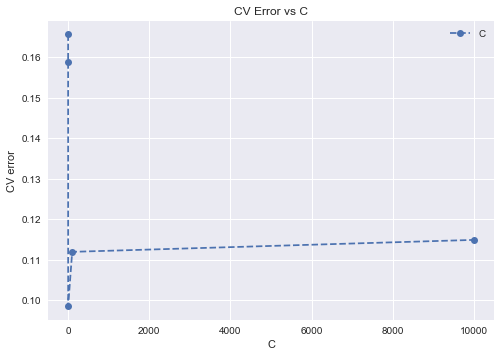

In [22]:
# To choose optimal c, call the linear svc utillity function

optimal_C_bow_grid = svc_grid_linear(std_X_train, y_train)

In [23]:
# instantiate learning model with optimal value
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_bow_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = clf.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [24]:
# calibrated train accuracy on train data
train_acc_bow_grid = calib.score(std_X_train, y_train)
print("Train accuracy:",train_acc_bow_grid)

Train accuracy: 0.9590428571428572


In [25]:
# roc_auc_score on test data
test_acc_bow_grid = roc_auc_score(y_test, pred_prob) * 100
print("\n Test accuracy", test_acc_bow_grid)


 Test accuracy 92.49539112796639


In [26]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 3197,   906],
       [ 2084, 23813]], dtype=int64)

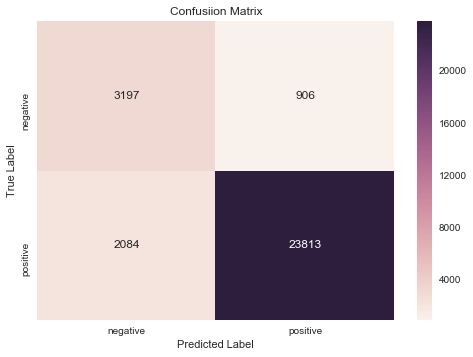

In [27]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [28]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.61      0.78      0.68      4103
           1       0.96      0.92      0.94     25897

   micro avg       0.90      0.90      0.90     30000
   macro avg       0.78      0.85      0.81     30000
weighted avg       0.91      0.90      0.91     30000



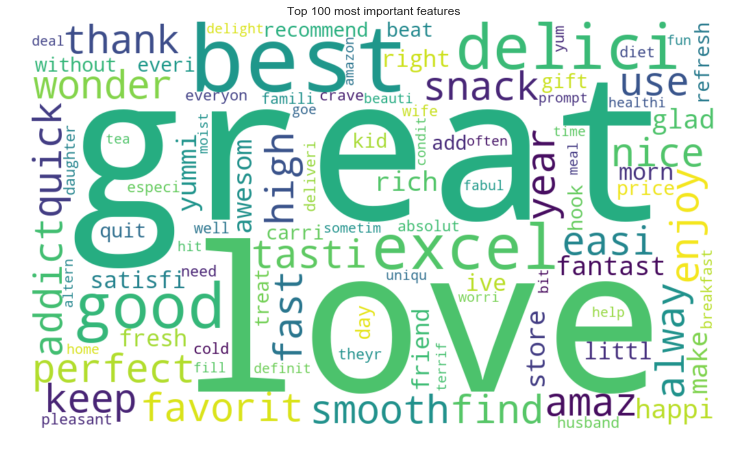

In [29]:
# Wordcloud of top 100 most important features obtained by applying linear svc
from wordcloud import WordCloud, STOPWORDS
# Get feature names 
# After training the model get word coefficient of each features
# Store feature names corresponding with weights or coefficient in a pandas DataFrame
features = bow.get_feature_names()
coef = clf.coef_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef.flatten()}, index = None)
# Sort coefficient in decending order and take top 100 weight
df = coef_df.sort_values("coeficient", ascending = False)[:100]
# store each word which has high weight in a cloud variable
cloud = " ".join(word for word in df.word)
# Remove duplicate words
stopwords = set(STOPWORDS) 
# call built-in method WordCloud for creating an object for drawing a word cloud 
# because we want to generate a wordcloud of top 100 features
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0) 
  
plt.show()

**Observations**<br>
1. We tuned hyperparameter using cross-validation where Optimal value of alpha(c) = 1, we get the good train accuracy and roc_auc score as well.
2. Applied linear svc using SGDClassifier on bag-of-words featurization and it generalize well on unseen data.
3. We have also used sigmoid calibration because when a classifier predict probability, it needs to be rescale.
4. Plotted top 100 most important features in a word cloud, where we found that the "great" and "love" is the most important feature.

## RBF SVC

In [31]:
# Tsking only 25k datapoints because of memory constraints
data = cleaned_data.iloc[:25000,:]
# Store features and class-label in x and y respectevely
X = data["CleanedText"]
y = data["Score"]
# Splitting data into train and test 
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)
# Apply Bow to get feature vector
bow = CountVectorizer(min_df = 10, max_features = 500)
X_train = bow.fit_transform(X_train)
x_test = bow.transform(x_test)
# Standardization
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)
std_x_test = scaler.fit_transform(x_test)

(17500,) (17500,) (7500,) (7500,)


In [32]:
# dimension of train and test data
print("Dimension of train and test data", std_X_train.shape ,std_x_test.shape)
n_train = std_X_train
n_test = std_x_test

Dimension of train and test data (17500, 500) (7500, 500)



**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8797951133029347


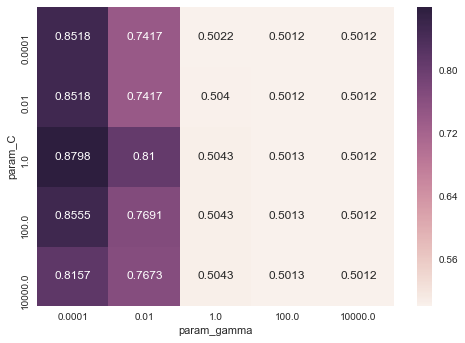

In [37]:
# To choose c and gamma, call the rbf utility function
optimal_C_bow_grid_rbf, optimal_gamma_bow_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [39]:
# instantiate learning model with optimal value
clf = SVC(C = optimal_C_bow_grid_rbf, gamma = optimal_gamma_bow_grid_rbf, kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [40]:
# Train accuracy
train_acc_bow_rbf = calib.score(std_X_train, y_train)
print("Train accuracy:", train_acc_bow_rbf)

Train accuracy: 0.9177142857142857


In [41]:
# auc_roc score
test_acc_bow_rbf = roc_auc_score(y_test, pred_prob) * 100
test_acc_bow_rbf

88.20522472162186

In [42]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 284,  579],
       [ 149, 6488]], dtype=int64)

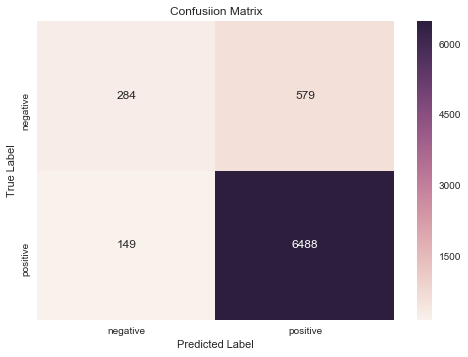

In [43]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [44]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.66      0.33      0.44       863
    positive       0.92      0.98      0.95      6637

   micro avg       0.90      0.90      0.90      7500
   macro avg       0.79      0.65      0.69      7500
weighted avg       0.89      0.90      0.89      7500



**Observations**</br>
1. We took only 25k datapoints and vectorize using bow and applied rbf svc.
2. By doing hyperparameter tuning, we get c and gamma value is 1 and 0.0001 respectively. Model Generalize good on test data. 

# Tf-Idf

## Linear SVC

In [45]:
# data
X = final_100k["CleanedText"]

In [46]:
# Target/class-label
y = final_100k["Score"]

In [47]:
# Split data
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [48]:
# Train vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tf_idf_vect = TfidfVectorizer()
X_train = tf_idf_vect.fit_transform(X_train)
X_train

<70000x31419 sparse matrix of type '<class 'numpy.float64'>'
	with 2104282 stored elements in Compressed Sparse Row format>

In [49]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [50]:
# Convert test text data to its vectorizor
x_test = tf_idf_vect.transform(x_test)
x_test.shape

(30000, 31419)

In [51]:
# Standardization
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 1

Best Score: 0.912597546007747


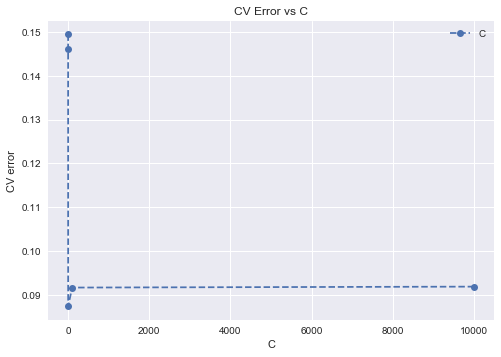

In [52]:
# To choose best C, call the linear svc utility function 
optimal_C_tfidf_grid  = svc_grid_linear(std_X_train, y_train)

In [53]:
# instantiate learning model
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_tfidf_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [54]:
# Train accuracy
train_acc_tfidf_grid = calib.score(std_X_train, y_train)
print("Train accuracy :", (train_acc_tfidf_grid))

Train accuracy : 0.9615


In [55]:
# roc_auc score
test_acc_tfidf_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_C_tfidf_grid, test_acc_tfidf_grid))


The accuracy of the logistic regression for c = 1.000000 is 92.49%


In [56]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 1900,  1717],
       [  652, 25731]], dtype=int64)

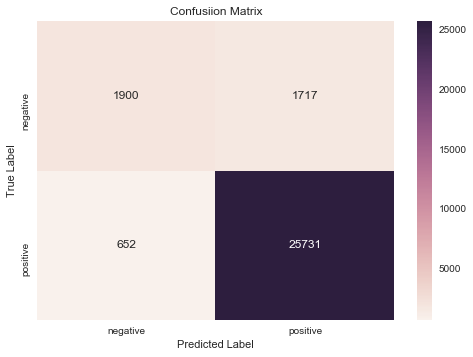

In [57]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [58]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62      3617
           1       0.94      0.98      0.96     26383

   micro avg       0.92      0.92      0.92     30000
   macro avg       0.84      0.75      0.79     30000
weighted avg       0.91      0.92      0.91     30000



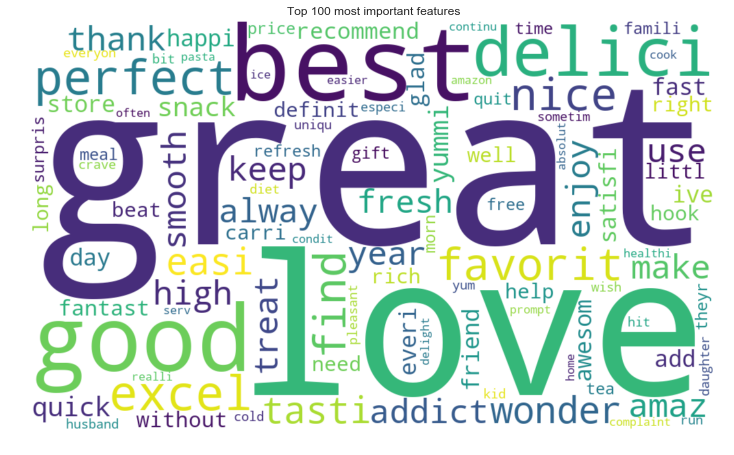

In [59]:
from wordcloud import WordCloud, STOPWORDS

features = tf_idf_vect.get_feature_names()
coef = clf.coef_
coef_df = pd.DataFrame({'word': features, 'coeficient': coef.flatten()}, index = None)
#print(coef_df)
#print(coef)
df = coef_df.sort_values("coeficient", ascending = False)[:100]
cloud = " ".join(word for word in df.word)
stopwords = set(STOPWORDS) 
wordcloud = WordCloud(width = 1000, height = 600, background_color ='white', stopwords = stopwords).generate(cloud) 
  
# plot the WordCloud image                        
plt.figure(figsize = (10, 8)) 
plt.imshow(wordcloud, interpolation = 'bilinear') 
plt.axis("off") 
plt.title("Top 100 most important features")
plt.tight_layout(pad = 0)  
plt.show() 

**Observations** <br>
1. We observe that when c value is 1, then the train score is slightly higher than the test score(roc_auc score). There might be change of overfitting.
2. From word cloud, We can also see that when we vectorize text using tfidf, the most important features is almost same as that we get using bow. 

## RBF SVC

In [60]:
# Tsking only 25k datapoints because of memory constraints 
data = cleaned_data.iloc[:25000,:]
X = data["CleanedText"]
y = data["Score"]
#print(X.shape, y.shape)
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, y_train.shape, x_test.shape, y_test.shape)
tfidf = TfidfVectorizer(min_df = 10, max_features = 500)
X_train = tfidf.fit_transform(X_train)
x_test = tfidf.transform(x_test)
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)
std_x_test = scaler.fit_transform(x_test)

(17500,) (17500,) (7500,) (7500,)


In [61]:
# Shape of train and test data
print("Dimension of train and test data", std_X_train.shape ,std_x_test.shape)
n_train = std_X_train
n_test = std_x_test

Dimension of train and test data (17500, 500) (7500, 500)



**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.0001

Best kernel: rbf

Best Score: 0.8728066054566755


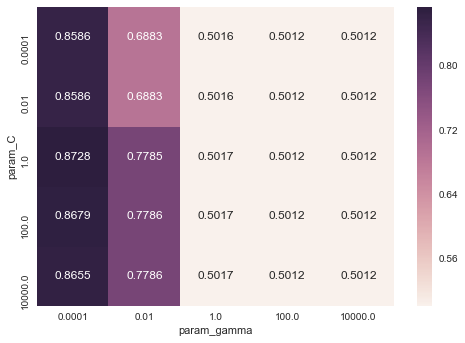

In [62]:
# To choose optimal C and gamma, call the rbf utility function 
optimal_C_tfidf_grid_rbf, optimal_gamma_tfidf_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [63]:
# instantiate learning model lambda = optimal_lambda
clf = SVC(C = optimal_C_tfidf_grid_rbf, gamma = optimal_gamma_tfidf_grid_rbf, kernel = "rbf", class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [64]:
# Train accuracy
train_acc_tfidf_grid_rbf = calib.score(std_X_train, y_train)
print("Training accuracy:", train_acc_tfidf_grid_rbf)

Training accuracy: 0.9206285714285715


In [65]:
# roc_auc score
test_acc_tfidf_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' %(optimal_C_tfidf_grid_rbf, test_acc_tfidf_grid_rbf))


The accuracy of the logistic regression for c = 1.000000 is 88.35%


In [66]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[ 296,  567],
       [ 162, 6475]], dtype=int64)

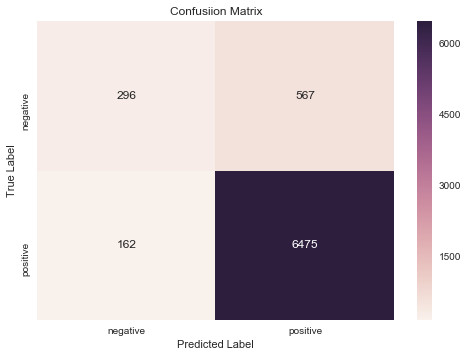

In [67]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [68]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

    negative       0.65      0.34      0.45       863
    positive       0.92      0.98      0.95      6637

   micro avg       0.90      0.90      0.90      7500
   macro avg       0.78      0.66      0.70      7500
weighted avg       0.89      0.90      0.89      7500



**Observations**
1. This model works same as the previous model.
2. In a nutshell we can say this model works well with unseen data and also have very similar roc_auc score comparison to bow representation.

# Word2vec

In [69]:
# data
X = final_100k["Text"]
X.shape

(100000,)

In [70]:
# Target/class-label
y = final_100k["Score"]
y.shape

(100000,)

In [71]:
# Split data into train and test
X_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42, shuffle = False)
print(X_train.shape, x_test.shape, y_train.shape, y_test.shape)

(70000,) (30000,) (70000,) (30000,)


In [72]:
import re
def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

In [73]:
# Train your own Word2Vec model using your own train text corpus
import gensim
list_of_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)

In [74]:
# train word2vec model
w2v_model_train = gensim.models.Word2Vec(list_of_sent, min_count=5, size=50, workers=4)

In [75]:
# Get most similar word of "like"
# By checking this we can be ensure that, our training is good 
w2v_model_train.wv.most_similar('like')

[('prefer', 0.6753042936325073),
 ('think', 0.6317151784896851),
 ('crave', 0.6017452478408813),
 ('mean', 0.5887060165405273),
 ('dislike', 0.5848040580749512),
 ('want', 0.5691789388656616),
 ('miss', 0.5672373175621033),
 ('know', 0.5593189597129822),
 ('love', 0.5565342903137207),
 ('enjoy', 0.5513074994087219)]

In [76]:
# To get vocabulary 
w2v_train = w2v_model_train[w2v_model_train.wv.vocab]

In [77]:
# Shape of trained word2vec
w2v_train.shape

(16156, 50)

In [78]:
# Train your own Word2Vec model using your own test text corpus
import gensim
list_of_sent_test = []
#for sent in final_40k['Text'].values:
for sent in x_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent_test.append(filtered_sentence)

In [79]:
# Train word2vec with your own corpus
w2v_model_test = gensim.models.Word2Vec(list_of_sent_test, min_count=5, size=50, workers=4)

In [80]:
w2v_model_test.wv.most_similar('like')

[('prefer', 0.6489608287811279),
 ('dislike', 0.5882995128631592),
 ('think', 0.5767476558685303),
 ('know', 0.5767325758934021),
 ('mean', 0.5702183842658997),
 ('ok', 0.5549999475479126),
 ('want', 0.5543765425682068),
 ('weird', 0.5532705783843994),
 ('awful', 0.5487860441207886),
 ('love', 0.5440407991409302)]

In [81]:
w2v_test = w2v_model_test[w2v_model_test.wv.vocab]

In [82]:
w2v_test.shape

(10801, 50)

# Average word2vec

## Linear SVC

In [83]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

70000
50


In [84]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_test = [] # the avg-w2v for each sentence/review is stored in this list
for sent in list_of_sent_test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0 # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model_test.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

30000
50


In [85]:
# Train data
X_train = sent_vectors

In [86]:
# Standardization of train data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [87]:
# Test data
x_test = sent_vectors_test

In [88]:
# Standardization of test data
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 0.01

Best Score: 0.8770534959444923


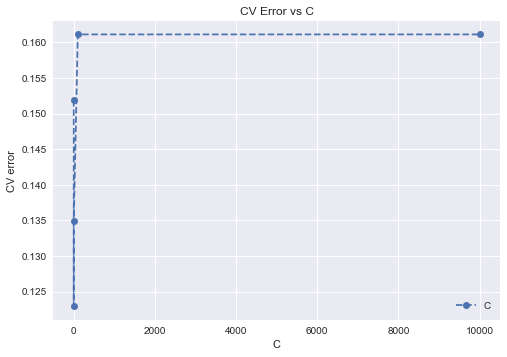

In [89]:
# To choose optimal C 
optimal_C_avgw2v_grid = svc_grid_linear(std_X_train, y_train)

In [90]:
# instantiate learning model lambda = optimal_lambda
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_avgw2v_grid, class_weight = "balanced", shuffle = False)
# fitting the model
clf.fit(std_X_train, y_train)
# linear svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [91]:
# Train acuracy
train_acc_avgw2v_grid = calib.score(std_X_train, y_train)
print("Train accuracy:", train_acc_avgw2v_grid)

Train accuracy: 0.8980428571428571


In [92]:
# roc_auc score
test_acc_avgw2v_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy of the logistic regression for c = %f is %.2f%%' % (optimal_C_avgw2v_grid, test_acc_avgw2v_grid))


The accuracy of the logistic regression for c = 0.010000 is 78.04%


In [93]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   53,  4050],
       [   41, 25856]], dtype=int64)

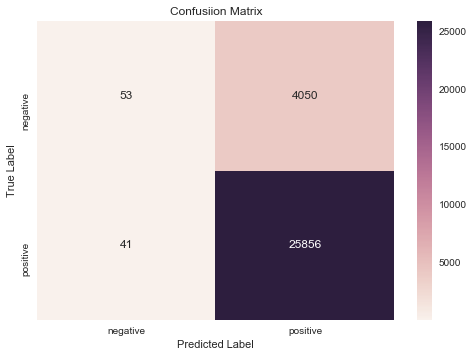

In [94]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [95]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.56      0.01      0.03      4103
           1       0.86      1.00      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.71      0.51      0.48     30000
weighted avg       0.82      0.86      0.80     30000



**Observations** <br>
1. We took 100k datapoints and vectorize text using word2vec. 
2. Tuned hyperparameter C and obtained validataion score and train score is approx same and roc_auc score is low.
3. We Get roc_auc score low and there is a chance of getting overfitting, this model does not works well.

## RBF SVC


**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.01

Best kernel: rbf

Best Score: 0.9003279881654626


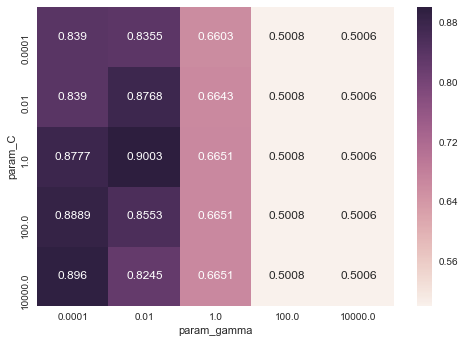

In [96]:
# To choose optimal C and gamma, call the rbf svc utility function 
optimal_C_avgw2v_grid_rbf, optimal_gamma_avgw2v_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [117]:
# instantiate learning model lambda = optimal_lambda
#lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow)
clf = SVC(C = optimal_C_avgw2v_grid_rbf, gamma = optimal_gamma_avgw2v_grid_rbf, kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
# rbf svc with sigmoid calibration
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [118]:
# Accuracy on train data
train_acc_avgw2v_grid_rbf = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_avgw2v_grid_rbf)

Train accuracy 0.9102428571428571


In [123]:
# roc_auc score
test_acc_avgw2v_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nTest accuracy is %.2f%%' % (test_acc_avgw2v_grid_rbf))


Test accuracy is 64.65%


In [121]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[   16,  4087],
       [   13, 25884]], dtype=int64)

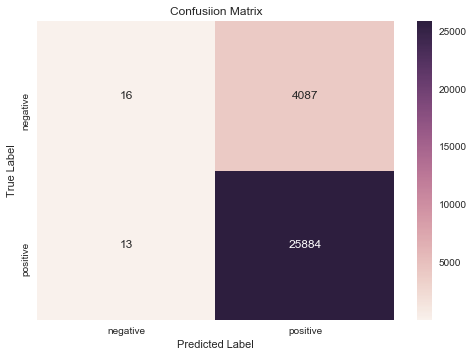

In [124]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [125]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.55      0.00      0.01      4103
           1       0.86      1.00      0.93     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.71      0.50      0.47     30000
weighted avg       0.82      0.86      0.80     30000



**Observations** <br>
1. After tuning hyperparameter we get c and gamma value 1 and 0.01 respectively and applied rbf svc.
2. We have also applied sigmoid calibration because this model is giving probabilistic output and We observe that model completly overfitting because the roc_auc score is significantly lower than train score. It does not generalize well.

# TFIDF Word2Vec

## Linear SVC

In [126]:
# load pre-trained train tfidf word2vec
import pickle
fp = open("tfidf_w2v_train", "rb")
X_train = pickle.load(fp)
fp.close()

In [127]:
# load pre-trained test tfidf word2vec 
fp = open("tfidf_w2v_test", "rb")
x_test = pickle.load(fp)
fp.close()

In [128]:
# Convert non to zero and large finite number to finite number for train data
# because we can not built model with nan or infine number
X_train = np.nan_to_num(X_train)
X_train

array([[-0.48349812,  0.75144427, -0.06594234, ...,  1.5028818 ,
         0.29948876, -0.44462803],
       [-0.04418715,  0.29029277,  0.17371265, ...,  1.51229542,
        -0.74874868, -0.22024703],
       [ 0.12420488, -0.4641343 ,  0.06444369, ...,  0.37105096,
        -0.25725251,  0.23438488],
       ...,
       [-0.57923008, -0.16192575,  0.8536063 , ..., -0.08538688,
        -0.41755286, -0.44779564],
       [-0.03978328, -1.55530164,  1.91665807, ...,  0.83137131,
        -0.67984484, -0.35482387],
       [ 0.63393515, -0.09246636,  0.57390971, ...,  2.11334634,
        -0.25369723, -0.78699488]])

In [129]:
# Standardization 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean = False)
std_X_train = scaler.fit_transform(X_train)

In [130]:
# Convert non to zero and large finite number to finite number for test data
x_test = np.nan_to_num(x_test)
x_test

array([[ 0.34593427, -0.33378229,  0.29876187, ...,  0.56542015,
         0.21190853, -0.40532353],
       [ 0.23345176, -0.27481742,  0.53645752, ...,  1.13393207,
         0.19772014, -0.46428262],
       [-0.08508098,  0.02154873,  0.53267926, ...,  0.97721448,
        -0.51473134, -0.94073504],
       ...,
       [-0.11953213, -0.01040013, -0.11163511, ..., -0.17898523,
        -0.1029216 , -0.68854281],
       [ 1.01604955, -0.87663854,  1.17348145, ...,  1.59237273,
         0.85651081, -0.21365862],
       [ 0.22494178, -0.18630779,  0.91438269, ...,  0.61373563,
        -1.27872778, -0.45772429]])

In [131]:
# Standardization on test data
scaler = StandardScaler(with_mean = False)
std_x_test = scaler.fit_transform(x_test)


**********GridSearchCV**********


Optimal C: 0.01

Best Score: 0.807502360285476


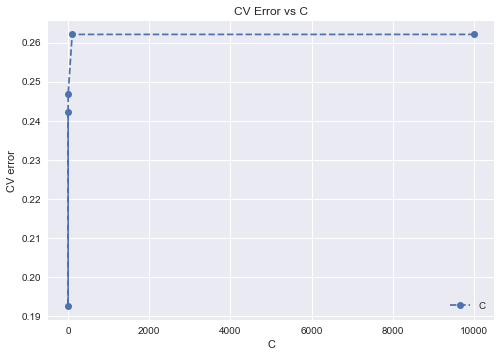

In [133]:
# To choose best C
optimal_C_tfidfw2v_grid = svc_grid_linear(std_X_train, y_train)

In [135]:
# instantiate learning model
clf = SGDClassifier(loss = "hinge", alpha = optimal_C_tfidfw2v_grid, class_weight = "balanced")
# fitting the model
clf.fit(std_X_train, y_train)
calib = CalibratedClassifierCV(clf, cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [136]:
# Accuracy on train data
train_acc_tfidfw2v_grid = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid)

Train accuracy 0.8854428571428572


In [137]:
# roc_auc score
test_acc_tfidfw2v_grid = roc_auc_score(y_test, pred_prob) * 100
print('\nThe accuracy for c = %0.3f is %f%%' % (optimal_C_tfidfw2v_grid, test_acc_tfidfw2v_grid))


The accuracy for c = 0.010 is 73.646818%


In [138]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  142,  3961],
       [  232, 25665]], dtype=int64)

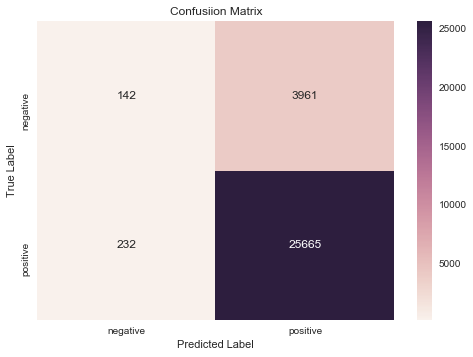

In [139]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [140]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.38      0.03      0.06      4103
           1       0.87      0.99      0.92     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.62      0.51      0.49     30000
weighted avg       0.80      0.86      0.81     30000



**Observations** <br>
1. This model Does not generalize well on unseen data and also looks like overfitting even after hyperparameter tuning.

## RBF SVC


**********GridSearchCV**********


Optimal C: 1

Optimal Gamma: 0.01

Best kernel: rbf

Best Score: 0.8301936300480336


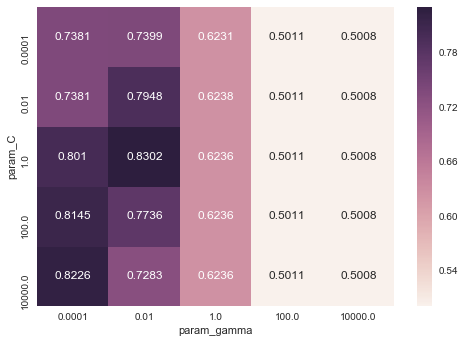

In [141]:
# Find optimal C and gamma for rbf svc 
optimal_C_tfidfw2v_grid_rbf, optimal_gamma_tfidfw2v_grid_rbf = svc_grid_rbf(std_X_train, y_train)

In [144]:
# instantiate learning model lambda = optimal_lambda
#lr_model =  LogisticRegression(penalty = 'l1', C = optimal_lambda_bow)
clf = SVC(C = optimal_C_tfidfw2v_grid_rbf, gamma = optimal_gamma_tfidfw2v_grid_rbf, kernel = "rbf", class_weight = "balanced", probability = True)
# fitting the model
clf.fit(std_X_train, y_train)
calib = CalibratedClassifierCV(clf, method = "sigmoid", cv = "prefit")
calib.fit(std_X_train, y_train)
# predict the response
pred = calib.predict(std_x_test)
# Predict probabilistic response
pred_prob = calib.predict_proba(std_x_test)[:,1]

In [145]:
# Accuracy on train data
train_acc_tfidfw2v_grid_rbf = calib.score(std_X_train, y_train)
print("Train accuracy", train_acc_tfidfw2v_grid_rbf)

Train accuracy 0.8943142857142857


In [147]:
# roc_auc score
test_acc_tfidfw2v_grid_rbf = roc_auc_score(y_test, pred_prob) * 100
print('\nThe test accuracy is %.2f%%' % (test_acc_tfidfw2v_grid_rbf))


The test accuracy is 71.65%


In [148]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, pred)
cm

array([[  128,  3975],
       [  220, 25677]], dtype=int64)

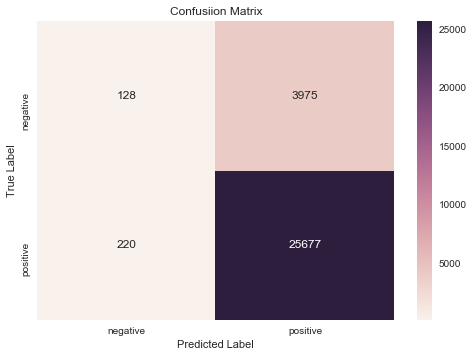

In [149]:
# plot confusion matrix to describe the performance of classifier.
import seaborn as sns
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusiion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [150]:
# To show main classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.37      0.03      0.06      4103
           1       0.87      0.99      0.92     25897

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.62      0.51      0.49     30000
weighted avg       0.80      0.86      0.81     30000



**Observations**
1. we found c and gamma value 1 and 0.01 using gridsearch cross validation and this model works quite similar as the linear svc on tfidf word2vec. 

**Conclusions** <br>
1. We applied 4 technique to vectorize text data and work with 2 version of svc linear and rbf. For linear svc using bow and tfidf, we took 100k data points and for kernel svc using same we took 25k datapoints as it is computationaly very expensive. For word2vec featurization we took 100k datapoints for both version on svc.
2. Did gridsearch cross validation and find hyperparameter c and gamma. 
3. We also calibrated using sigmoid method as both version of svc is giving probabilisitc output. Calibration is necessary when we get probabilities score but not for all model as we do not need it for logistic regression because the predicted probabilities is already calibrated. https://machinelearningmastery.com/calibrated-classification-model-in-scikit-learn/
4. We observe that svc worked really well with bow, tfidf representation of text data and did not perform well on word2vec representation of text data.
5. At the end of this cell, provided overall summery of model which will help to understand model performence completly in a single go.

In [162]:
# model performence table using grid search
import itable
models = pd.DataFrame({'Model': ['Linear SVC with Bow', "Linear SVC with TFIDF", "Linear SVC with avgw2v", "Linear SVC with TFIDFW2V"],
                       'Hyper Parameter(C)': [optimal_C_bow_grid, optimal_C_tfidf_grid, optimal_C_avgw2v_grid, optimal_C_tfidfw2v_grid ],
                       'Train Error': [1-train_acc_bow_grid, 1-train_acc_tfidf_grid, 1-train_acc_avgw2v_grid, 1-train_acc_tfidfw2v_grid], 
                       'Test Error': [100-test_acc_bow_grid, 100-test_acc_tfidf_grid, 100-test_acc_avgw2v_grid, 100-test_acc_tfidfw2v_grid], 'Roc_Auc_Score': [test_acc_bow_grid, test_acc_tfidf_grid, test_acc_avgw2v_grid, test_acc_tfidfw2v_grid]}, columns = ["Model", "Hyper Parameter(C)", "Train Error", "Test Error", "Roc_Auc_Score"])
itable.PrettyTable(models, tstyle=itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(C),Train Error,Test Error,Roc_Auc_Score
0,Linear SVC with Bow,1.0,0.0409571428571428,7.504608872033614,92.49539112796639
1,Linear SVC with TFIDF,1.0,0.03849999999999998,7.50638148024521,92.49361851975479
2,Linear SVC with avgw2v,0.01,0.10195714285714286,21.96032199439179,78.03967800560821
3,Linear SVC with TFIDFW2V,0.01,0.1145571428571428,26.353181929376163,73.64681807062384


In [167]:
# model performence table using random search
models = pd.DataFrame({'Model': ['RBF SVC with Bow', "RBF SVC with TFIDF", "RBF SVC with avgw2v", "RBF SVC  with TFIDFW2V"],
                       'Hyper Parameter(C)': [optimal_C_bow_grid_rbf, optimal_C_tfidf_grid_rbf, optimal_C_avgw2v_grid_rbf, optimal_C_tfidfw2v_grid_rbf],
                       "Hyper Parameter(gamma)": [optimal_gamma_bow_grid_rbf, optimal_gamma_tfidf_grid_rbf, optimal_gamma_avgw2v_grid_rbf, optimal_gamma_tfidfw2v_grid_rbf],
                       'Train Error': [1-train_acc_bow_rbf, 1-train_acc_tfidf_grid_rbf, 1-train_acc_avgw2v_grid_rbf, 1-train_acc_tfidfw2v_grid_rbf],
                       'Test Error': [100-test_acc_bow_rbf, 100-test_acc_tfidf_grid_rbf, 100-test_acc_avgw2v_grid_rbf, 100-test_acc_tfidfw2v_grid_rbf], 'Roc_Auc_Score': [test_acc_bow_rbf, test_acc_tfidf_grid_rbf, test_acc_avgw2v_grid_rbf, test_acc_tfidfw2v_grid_rbf]}, columns = ["Model", "Hyper Parameter(C)", "Hyper Parameter(gamma)", "Train Error", "Test Error", "Roc_Auc_Score"])
itable.PrettyTable(models, tstyle=itable.TableStyle(theme = "theme1"), center = True, header_row = True)

,Model,Hyper Parameter(C),Hyper Parameter(gamma),Train Error,Test Error,Roc_Auc_Score
0,RBF SVC with Bow,1,0.0001,0.0822857142857143,11.79477527837814,88.20522472162186
1,RBF SVC with TFIDF,1,0.0001,0.07937142857142854,11.645012658590275,88.35498734140972
2,RBF SVC with avgw2v,1,0.01,0.08975714285714287,35.34972639647056,64.65027360352944
3,RBF SVC with TFIDFW2V,1,0.01,0.10568571428571427,28.347468506327374,71.65253149367263
